# Ex08

#### 1. import 하기

In [1]:
! pip install --upgrade konlpy==0.5.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.5
0.5.2
3.6.0


#### konlpy

In [3]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:8 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists...
Reading package lists...
Building dependency tree...
Rea

In [4]:
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

env: JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"


In [5]:
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /tmp/mecab-python-0.996
  Created wheel for mecab-python: filename=mecab_python-0.996_ko_0.9.2-cp37-cp37m-linux_x86_64.whl size=141810 sha256=d4970e75769c010b9f5261b9101816307d71e4ddf098813b03b066476609aa68
  Stored in directory: /root/.cache/pip/wheels/40/7b/9f/2922869bef86c3354ae7034f7a3647c573ee1997c2dad0290a
Failed to build mecab-python
  Attempting uninstall: mecab-python
    Found existing installation: mecab-python 0.996-ko-0.9.2
    Uninstalling mecab-python-0.996-ko-0.9.2:
      Successfully uninstalled mecab-python-0.996-ko-0.9.2
    Running setup.py install for mecab-python: started
    Running setup.py install for mecab-python: finished with status 'done'


  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  DEPRECATION: mecab-python was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


### 2. 데이터 준비

In [6]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import pandas as pd

train_data = pd.read_table('/content/drive/MyDrive/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 3. 데이터로더 구성

실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공한다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작한다. data_loader 안에서는 다음을 수행해야 합니다.

1. 데이터의 중복 제거
2. NaN 결측치 제거
3. 한국어 토크나이저로 토큰화
4. 불용어(Stopwords) 제거
5. 사전word_to_index 구성
6. 텍스트 스트링을 사전 인덱스 스트링으로 변환
7. X_train, y_train, X_test, y_test, word_to_index 리턴

In [8]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):

    # 중복된 값, 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [9]:
# 딕셔너리로 만들기
index_to_word = {index:word for word, index in word_to_index.items()}

In [10]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 4. 모델 구성을 위한 데이터 분석 및 가공

#### 문장 길이 분포, 적절한 최대 문장 길이 지정

In [11]:
# 다운로드한 데이터 실제 예시 확인

print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


숫자로 encode된 데이터가 잘 나오는 것을 알 수 있다.

In [12]:
# 문장 길이 파악

total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))


문장길이 평균 :  15.969355837799927
문장길이 최대 :  116
문장길이 표준편차 :  12.843536204665021


문장 최대 길이 maxlen의 값 설정도 전체 모델 성능에 영향을 미치게 된다. 이 길이도 적절한 값을 찾기 위해서 데이터셋의 분포를 확인해 보는 것이 좋다.

In [13]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


#### keras.preprocessing.sequence.pad_sequences을 활용한 패딩 추가

In [14]:
import tensorflow as tf
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 패딩 순서
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 패딩 순서
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


### 5. 모델 구성 및 validation set 구성

In [15]:
from tensorflow import keras

vocab_size = 10000  # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16   # 워드 벡터의 차원 수 (변경 가능한 하이퍼 파라미터). 

# LSTM
lstm = keras.Sequential()
lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm.add(keras.layers.LSTM(8))
lstm.add(keras.layers.Dense(8, activation='relu'))
lstm.add(keras.layers.Dense(1, activation='sigmoid'))

lstm.summary()

# 1-D CNN
cnn = keras.Sequential()
cnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))) 
cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn.add(keras.layers.MaxPooling1D(5))
cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn.add(keras.layers.GlobalMaxPooling1D())
cnn.add(keras.layers.Dense(16, activation='relu'))
cnn.add(keras.layers.Dense(1, activation='sigmoid'))

cnn.summary()

# one GlobalAveragePooling layer
simple = keras.Sequential()
simple.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
simple.add(keras.layers.GlobalAveragePooling1D())
simple.add(keras.layers.Dense(8, activation='relu'))
simple.add(keras.layers.Dense(1, activation='sigmoid'))

simple.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)    

In [16]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


### 6. 모델 훈련 개시

In [17]:
epochs = 5

lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_lstm = lstm.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 10s 11ms/step - loss: 0.4790 - accuracy: 0.7839 - val_loss: 0.3570 - val_accuracy: 0.8458
Epoch 2/5
266/266 [==============================] - 3s 12ms/step - loss: 0.3383 - accuracy: 0.8565 - val_loss: 0.3440 - val_accuracy: 0.8497
Epoch 3/5
266/266 [==============================] - 2s 9ms/step - loss: 0.3173 - accuracy: 0.8676 - val_loss: 0.3437 - val_accuracy: 0.8519
Epoch 4/5
266/266 [==============================] - 2s 8ms/step - loss: 0.3055 - accuracy: 0.8729 - val_loss: 0.3513 - val_accuracy: 0.8455
Epoch 5/5
266/266 [==============================] - 2s 8ms/step - loss: 0.2948 - accuracy: 0.8779 - val_loss: 0.3405 - val_accuracy: 0.8529


In [18]:
epochs = 3

cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


history_cnn = cnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/3
266/266 [==============================] - 9s 8ms/step - loss: 0.4843 - accuracy: 0.7559 - val_loss: 0.3515 - val_accuracy: 0.8493
Epoch 2/3
266/266 [==============================] - 2s 7ms/step - loss: 0.3268 - accuracy: 0.8608 - val_loss: 0.3396 - val_accuracy: 0.8500
Epoch 3/3
266/266 [==============================] - 2s 7ms/step - loss: 0.2945 - accuracy: 0.8779 - val_loss: 0.3345 - val_accuracy: 0.8551


In [19]:
# 1-D CNN과 동일하게 3 epochs로 진행

simple.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_simple = simple.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/3
266/266 [==============================] - 3s 6ms/step - loss: 0.6302 - accuracy: 0.7309 - val_loss: 0.5196 - val_accuracy: 0.8020
Epoch 2/3
266/266 [==============================] - 2s 6ms/step - loss: 0.4434 - accuracy: 0.8226 - val_loss: 0.3955 - val_accuracy: 0.8375
Epoch 3/3
266/266 [==============================] - 1s 6ms/step - loss: 0.3735 - accuracy: 0.8443 - val_loss: 0.3633 - val_accuracy: 0.8434


#### 모델 평가

In [20]:
# lstm 모델 평가
results = lstm.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.3548 - accuracy: 0.8472 - 5s/epoch - 3ms/step
[0.35478514432907104, 0.847163200378418]


In [21]:
# cnn 모델 평가
results = cnn.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3464 - accuracy: 0.8504 - 4s/epoch - 3ms/step
[0.346358060836792, 0.8503569960594177]


In [22]:
# simple 모델 평가
results = simple.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3770 - accuracy: 0.8397 - 3s/epoch - 2ms/step
[0.37699246406555176, 0.8396565914154053]


### 7. Loss, Accuracy 그래프 시각화

#### lstm 그래프

In [23]:
history_dict = history_lstm.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


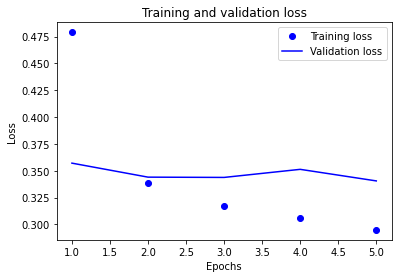

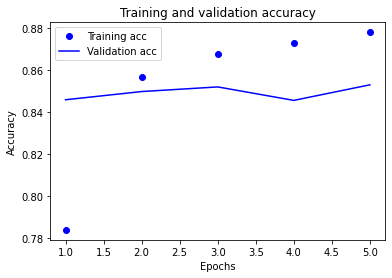

In [24]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

오잉 ? 그래프가 무슨 모양이람. epoch 2.0이 이상적인 횟순가 ?

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


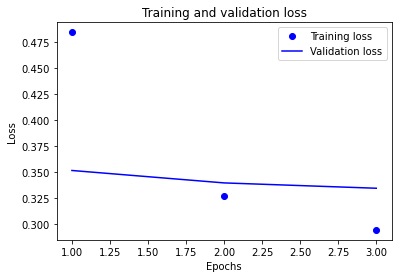

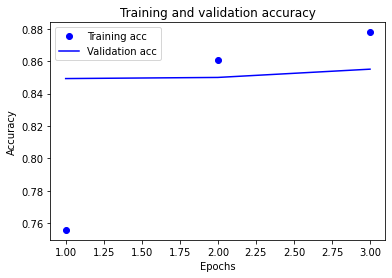

In [25]:
history_dict = history_cnn.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

# 그래프 설정
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

cnn도 epoch 2가 이상치 같다.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


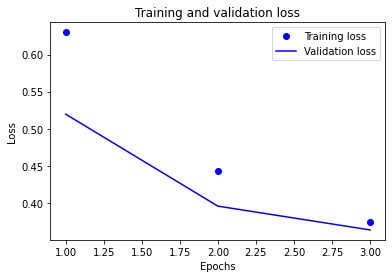

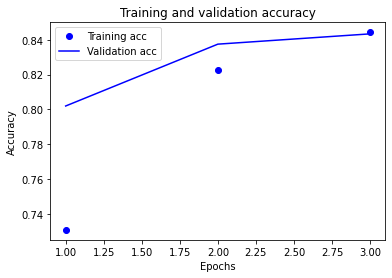

In [26]:
history_dict = history_simple.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

# 그래프 설정
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

simple도 epoch 2가 이상치 같다.

### 8. 학습된 Embedding 레이어 분석

#### lstm 레이어 분석

In [27]:
embedding_layer = lstm.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [28]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = '/content/drive/MyDrive/lstm_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = lstm.get_weights()[0]
for i in range(vocab_size-4):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [29]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([-0.00330914,  0.0441384 , -0.00515891,  0.038287  , -0.00202451,
        0.04553212, -0.01922024,  0.18950747,  0.05607818, -0.04214149,
       -0.03748826, -0.01298746,  0.02578745,  0.01646704,  0.01348987,
       -0.02764701], dtype=float32)

In [30]:
word_vectors.similar_by_word("재미")

[('말론', 0.8652044534683228),
 ('기대', 0.8622832298278809),
 ('전문', 0.857418954372406),
 ('ㅋ', 0.8460433483123779),
 ('흐흐', 0.8372098207473755),
 ('송', 0.8348487019538879),
 ('까지', 0.823746919631958),
 ('층', 0.8165277242660522),
 ('상어', 0.8160598278045654),
 ('공감', 0.8159261345863342)]

#### cnn 레이어 분석

In [31]:
embedding_layer = cnn.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = '/content/drive/MyDrive/cnn_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = cnn.get_weights()[0]
for i in range(vocab_size-4):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

(10000, 16)


array([ 1.29358590e-01,  2.43884418e-02, -1.23069085e-01,  5.93620026e-03,
       -5.68875391e-03, -9.47843946e-05,  8.64322297e-03,  1.57834470e-01,
       -1.62396356e-02,  6.83561042e-02, -2.76512057e-02,  9.46308449e-02,
        1.89728811e-02, -5.74643947e-02,  3.66788805e-02, -1.95773527e-01],
      dtype=float32)

In [32]:
word_vectors.similar_by_word("재미")

[('그래서', 0.8858275413513184),
 ('되게', 0.8838092684745789),
 ('손예진', 0.8681988716125488),
 ('너무', 0.844096302986145),
 ('이렇게', 0.8418799638748169),
 ('골든', 0.8388296365737915),
 ('최대', 0.8341493606567383),
 ('파치노', 0.8318309783935547),
 ('이즈', 0.8294464945793152),
 ('매우', 0.8291264772415161)]

#### simple 레이어 분석

In [33]:
embedding_layer = simple.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = '/content/drive/MyDrive/cnn_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = simple.get_weights()[0]
for i in range(vocab_size-4):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

(10000, 16)


array([ 0.02194844,  0.14134087,  0.23641469, -0.10853373, -0.11683071,
       -0.131848  , -0.06863674, -0.13286333, -0.09002455,  0.08866904,
        0.12181088,  0.13247685,  0.04162931,  0.1574577 , -0.07227208,
        0.04248695], dtype=float32)

In [34]:
word_vectors.similar_by_word("재미")

[('만드', 0.9715955257415771),
 ('돼', 0.9651026725769043),
 ('어쩔', 0.9648144841194153),
 ('조사', 0.9643312692642212),
 ('적합', 0.9642693996429443),
 ('결국', 0.9635778069496155),
 ('주인공', 0.9617049694061279),
 ('돌아왔', 0.9614879488945007),
 ('탐험', 0.9612845778465271),
 ('어디', 0.9605869054794312)]

### 9. 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [146]:
from gensim.models import KeyedVectors

word2vec_path = '/content/drive/MyDrive/word2vec_ko.model'
word2vec = KeyedVectors.load(word2vec_path)
wordwvec = word2vec.wv
vector = word2vec['액션']
vector     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([ 0.65723526, -1.070157  , -2.3446374 ,  2.8594716 , -0.34713092,
        0.668696  , -2.4143796 , -1.4441289 , -0.16029646, -1.4712427 ,
        1.1536198 , -3.2049558 , -2.2405772 , -1.0061163 ,  2.2915163 ,
        0.92053074, -1.4584308 , -0.6331175 ,  1.3004749 , -0.15487342,
        0.7282414 ,  0.40170607,  0.9353962 ,  0.2707452 , -0.3806664 ,
       -0.93675935, -0.21311992,  2.7702115 ,  1.8833528 ,  2.4775555 ,
       -3.3762197 ,  2.911479  ,  1.430429  , -0.51551604, -0.40317178,
        3.3471339 ,  0.7375594 , -1.493322  , -0.17728616, -2.9328263 ,
        2.8454707 , -3.696323  , -0.505087  ,  2.495022  ,  3.610891  ,
        0.66887   ,  3.2935026 , -1.6120412 ,  1.4075767 , -2.642688  ,
       -1.132086  ,  1.0686797 ,  0.4646657 , -3.3421419 ,  1.9832977 ,
        1.7219818 ,  3.172932  , -1.9722153 ,  0.21380153, -1.6865183 ,
        0.40586528,  2.2379217 ,  1.6365439 , -1.2445652 , -0.06904269,
       -0.29885393,  0.347748  ,  2.206415  , -0.19040611,  0.48

In [147]:
word2vec.similar_by_word("액션")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('코미디', 0.7429822683334351),
 ('스릴러', 0.7381718754768372),
 ('판타지', 0.6900153160095215),
 ('호러', 0.6892675757408142),
 ('SF', 0.6889280676841736),
 ('롤플레잉', 0.6625269651412964),
 ('영화', 0.6522793769836426),
 ('서스펜스', 0.645000696182251),
 ('어드벤처', 0.6273845434188843),
 ('미스터리', 0.6250677108764648)]

비슷해 보이지만, 유사도가 높진 않다.

In [148]:
import numpy as np
vocab_size = 10000   # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [149]:
# LSTM
lstm = keras.Sequential()
lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm.add(keras.layers.LSTM(8))
lstm.add(keras.layers.Dense(8, activation='relu'))
lstm.add(keras.layers.Dense(1, activation='sigmoid'))

lstm.summary()

# 1-D CNN
cnn = keras.Sequential()
cnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))) 
cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn.add(keras.layers.MaxPooling1D(5))
cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn.add(keras.layers.GlobalMaxPooling1D())
cnn.add(keras.layers.Dense(16, activation='relu'))
cnn.add(keras.layers.Dense(1, activation='sigmoid'))

cnn.summary()

# one GlobalAveragePooling layer
simple = keras.Sequential()
simple.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
simple.add(keras.layers.GlobalAveragePooling1D())
simple.add(keras.layers.Dense(16, activation='relu'))
simple.add(keras.layers.Dropout(0.1))
simple.add(keras.layers.Dense(1, activation='sigmoid'))
simple.summary()

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_48 (Embedding)    (None, None, 100)         1000000   
                                                                 
 lstm_16 (LSTM)              (None, 8)                 3488      
                                                                 
 dense_113 (Dense)           (None, 8)                 72        
                                                                 
 dense_114 (Dense)           (None, 1)                 9         
                                                                 
Total params: 1,003,569
Trainable params: 1,003,569
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_49 (Embed

In [150]:
epochs = 5

lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_lstm = lstm.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)
cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 3

history_cnn = cnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)
                    
epochs = 4

simple.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_simple = simple.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 5s 11ms/step - loss: 0.4555 - accuracy: 0.8015 - val_loss: 0.3484 - val_accuracy: 0.8511
Epoch 2/5
266/266 [==============================] - 2s 9ms/step - loss: 0.3260 - accuracy: 0.8633 - val_loss: 0.3316 - val_accuracy: 0.8552
Epoch 3/5
266/266 [==============================] - 2s 9ms/step - loss: 0.2988 - accuracy: 0.8758 - val_loss: 0.3297 - val_accuracy: 0.8590
Epoch 4/5
266/266 [==============================] - 2s 9ms/step - loss: 0.2780 - accuracy: 0.8857 - val_loss: 0.3349 - val_accuracy: 0.8577
Epoch 5/5
266/266 [==============================] - 2s 9ms/step - loss: 0.2593 - accuracy: 0.8952 - val_loss: 0.3383 - val_accuracy: 0.8579
Epoch 1/3
266/266 [==============================] - 3s 8ms/step - loss: 0.4374 - accuracy: 0.7927 - val_loss: 0.3371 - val_accuracy: 0.8545
Epoch 2/3
266/266 [==============================] - 2s 7ms/step - loss: 0.3016 - accuracy: 0.8726 - val_loss: 0.3212 - val_accuracy: 0.8595
Epoch 3/3
26

In [151]:
# LSTM
results_lstm = lstm.evaluate(X_test, y_test, verbose=3)
print(results_lstm)

# 1-D CNN
results_cnn = cnn.evaluate(X_test, y_test, verbose=3)
print(results_cnn)

# one GlobalAveragePooling1D layer
results_simple = simple.evaluate(X_test, y_test, verbose=3)
print(results_simple)

[0.3523094356060028, 0.8508452773094177]
[0.34400269389152527, 0.8545476794242859]
[0.36249470710754395, 0.8414671421051025]


# 회고

이번 익스는 너무 재밌었다. 가장 실용적인 공부를 한 것 같다.

하지만, 다 완성하고 제출하기 전에 찝찝한 것은 어쩔 수 없는 거 같다.

왜 one GlobalAveragePolling1D layer은 마의 85%를 깨지 못하는 걸까 ㅠㅠㅠㅠ cs231, 딥러닝 스터디, 노드에서 공부한 것을 적용해도 숫자를 넘기지 못했다. 이론 공부를 열심히 공부하여 잘 이해했다고 생각했지만, 왜 적용만 시키면 내가 생각하는 결과와 항상 다르게 나오는 지...ㅠ 더욱 열심히 해봐야겠다.

여담이지만, 다른 모델링과는 다르게, epoch를 낮게 줘도 되는 이유도 한 번 더 고심해봐야겠다. 방대한 댓글 양을 2번, 3번만 학습해도 test set을 잘 예측할 수 있는 이유가 궁금하다. 다른 것들은 30번 넘게 돌려도 원하는 정확성에 도달하지 못하는 경우도 허다하니깐....

뭐 다들 상대적인 거고 모델마다 원하는 수치가 다른 건 당연하다. 아마 이 수치를 잘 때려맞춰 하이퍼 파라미터에 잘 적용하는 사람이 이 학문에서 요구하는 인재상이 아닐까?라는 생각도 든다.

ㅡ